# Importing Libraries

In [32]:
# Linear Algebra
import numpy as np 

# Data Processing
import pandas as pd 
import datetime
import sklearn
from numpy import array
from pandas import DataFrame

# Data Visualization
import seaborn as sns
from matplotlib import pyplot 
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

#IESEG Functions
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

# Reading the Data

In [2]:
campaigns_df = pd.read_csv("campaigns.csv", sep=';')
donors_df = pd.read_csv("donors.csv", sep=';')
gifts_df = pd.read_csv("gifts.csv", sep=';')
camp6169_df = pd.read_csv("selectioncampaign6169.csv", sep=';') #train data frame
camp7244_df = pd.read_csv("selectioncampaign7244.csv", sep=';') #test data frame

# Cleaning the DataFrames 

### Creation of Age in Donors Dataframe

In [3]:
donors_df['age'] = donors_df.apply(lambda x: datetime.date.today().year -  (datetime.datetime.strptime(x.dateOfBirth,'%Y-%m-%d')).year, axis = 1 )
donors_df

,donorID,zipcode,province,region,gender,language,dateOfBirth,age
0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53
1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,68
2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,34
3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,68
4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,34
...,...,...,...,...,...,...,...,...
44686,144687,4900.0,Liege,Wallonia,M,FR,1970-09-12,50
44687,144688,3600.0,Limburg,Flanders,M,NL,1972-11-28,48
44688,144689,3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,53
44689,144690,1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,44


### Creation of Campaign 6169 DataFrame

In [4]:
#Merged with Gifts Dataset
campaign6169_merge = camp6169_df.merge(gifts_df, on = 'donorID', how = 'left')

#Second merge with Campaign Dataset
campaign6169_merge2 = campaign6169_merge.merge(campaigns_df, on = 'campaignID', how = 'left')

#Modified Date Columns to help understand the first two merge
campaign6169_merge2 = campaign6169_merge2.rename(columns={'date_x':'gift_date','date_y':'campaign_date'})

#Third Merge with Donor Dataset
campaign6169_merge3 = campaign6169_merge2.merge(donors_df, on = 'donorID', how = 'left')
campaign6169_merge3

,donorID,campaignID,amount,gift_date,campaign_date,lettersSent,CostUnit,zipcode,province,region,gender,language,dateOfBirth,age
0,100001,NaN,12.39,2004-03-23,NaN,NaN,NaN,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53.0
1,100001,1577.0,12.39,2007-10-11,09/10/2007,34 636,"0,31 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53.0
2,100001,1634.0,6.69,2007-12-28,08/12/2007,34 080,"0,21 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53.0
3,100001,1778.0,24.79,2008-06-14,25/05/2008,30 558,"0,41 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53.0
4,100001,1808.0,7.44,2008-07-09,22/06/2008,39 664,"0,61 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151747,144689,5326.0,100.00,2018-06-25,08/06/2018,39 445,"0,30 €",3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,53.0
151748,144689,7212.0,100.00,2019-05-01,26/04/2019,28 592,"0,06 €",3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,53.0
151749,144689,7519.0,200.00,2019-12-06,26/11/2019,35 199,"0,36 €",3061.0,Flemish Brabant,Flanders,M,NL,1967-04-21,53.0
151750,144690,3941.0,40.00,2014-12-30,25/12/2014,37 833,"0,50 €",1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,44.0


#### Filter Campaign6169 executed on September 4 2018

In [5]:
#Created Dataframe that filtered for Campaign 6169
camp6169 = campaign6169_merge3[campaign6169_merge2['campaignID']==6169]
camp6169

#Filter Campaign 6169 for 04/09/2018
camp6169 = camp6169[camp6169['campaign_date']=='04/09/2018']
camp6169

,donorID,campaignID,amount,gift_date,campaign_date,lettersSent,CostUnit,zipcode,province,region,gender,language,dateOfBirth,age
87,100023,6169.0,15.0,2018-09-15,04/09/2018,34 888,"0,87 €",1150.0,Brussels,Brussels,M,FR,1955-07-19,65.0
542,100126,6169.0,123.0,2018-09-11,04/09/2018,34 888,"0,87 €",1150.0,Brussels,Brussels,M,NL,1988-01-30,32.0
797,100253,6169.0,120.0,2018-09-18,04/09/2018,34 888,"0,87 €",1500.0,Flemish Brabant,Flanders,M,NL,1958-06-08,62.0
949,100279,6169.0,75.0,2018-09-13,04/09/2018,34 888,"0,87 €",1601.0,Flemish Brabant,Flanders,M,NL,1974-11-30,46.0
1303,100320,6169.0,135.0,2018-09-09,04/09/2018,34 888,"0,87 €",1730.0,Flemish Brabant,Flanders,F,NL,1980-06-21,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151519,144618,6169.0,60.0,2018-09-22,04/09/2018,34 888,"0,87 €",8400.0,West Flanders,Flanders,F,NL,1986-05-06,34.0
151529,144621,6169.0,30.0,2018-09-22,04/09/2018,34 888,"0,87 €",1703.0,Flemish Brabant,Flanders,M,NL,1960-09-22,60.0
151531,144622,6169.0,120.0,2018-09-16,04/09/2018,34 888,"0,87 €",8800.0,West Flanders,Flanders,F,NL,1938-12-21,82.0
151535,144623,6169.0,15.0,2018-09-22,04/09/2018,34 888,"0,87 €",8310.0,West Flanders,Flanders,M,NL,1972-06-30,48.0


In [6]:
#### Reviewing Null Values

In [7]:
camp6169.isnull().sum()

donorID           0
campaignID        0
amount            0
gift_date         0
campaign_date     0
lettersSent       0
CostUnit          0
zipcode          15
province         14
region           14
gender           14
language         14
dateOfBirth      14
age              14
dtype: int64

In [8]:
# Replace null/missing using median for Zipcode
median_zipcode = camp6169['zipcode'].median()
camp6169['zipcode'].fillna(median_zipcode, inplace=True)

#Replacing null/missing object value of Province based on normalized distribution
s = camp6169.province.value_counts(normalize=True)
print(s)
missing = camp6169['province'].isnull()
camp6169.loc[missing,'province']=np.random.choice(s.index, size=len(camp6169[missing]),p=s.values)
#print(camp6169)

#Replacing null/missing object value of Region based on normalized distribution
t = camp6169.region.value_counts(normalize=True)
print(t)
missing_t = camp6169['region'].isnull()
camp6169.loc[missing_t,'region']=np.random.choice(t.index, size=len(camp6169[missing_t]),p=t.values)

#Replacing null/missing object value of Gender based on normalized distribution
u = camp6169.gender.value_counts(normalize=True)
print(u)
missing_u = camp6169['gender'].isnull()
camp6169.loc[missing_u,'gender']=np.random.choice(u.index, size=len(camp6169[missing_u]),p=u.values)

#Replacing null/missing object value of Language based on normalized distribution
v = camp6169.language.value_counts(normalize=True)
print(v)
missing_v = camp6169['language'].isnull()
camp6169.loc[missing_v,'language']=np.random.choice(v.index, size=len(camp6169[missing_v]),p=v.values)

#Replacing null/missing object value of DateofBirth based on normalized distribution
w = camp6169.dateOfBirth.value_counts(normalize=True)
print(w)
missing_w = camp6169['dateOfBirth'].isnull()
camp6169.loc[missing_w,'dateOfBirth']=np.random.choice(w.index, size=len(camp6169[missing_w]),p=w.values)

# Replace null/missing using median for Age
median_age = camp6169['age'].median()
camp6169['age'].fillna(median_age, inplace=True)


camp6169.isnull().sum()
camp6169

East Flanders      0.231946
Antwerp            0.227698
West Flanders      0.201359
Flemish Brabant    0.159728
Limburg            0.111300
Brussels           0.022090
Liege              0.018692
Hainaut            0.011045
Namur              0.006797
Luxembourg         0.005098
Walloon Brabant    0.003398
Missing            0.000850
Name: province, dtype: float64
Flanders    0.932031
Wallonia    0.045030
Brussels    0.022090
Missing     0.000850
Name: region, dtype: float64
F    0.662702
M    0.337298
Name: gender, dtype: float64
NL    0.928632
FR    0.070518
EN    0.000850
Name: language, dtype: float64
1950-08-03    0.002549
1959-09-19    0.001699
1965-08-27    0.001699
1958-11-29    0.001699
1961-01-24    0.001699
                ...   
1974-12-06    0.000850
1960-05-03    0.000850
1961-11-21    0.000850
1929-09-21    0.000850
1958-09-02    0.000850
Name: dateOfBirth, Length: 1146, dtype: float64


,donorID,campaignID,amount,gift_date,campaign_date,lettersSent,CostUnit,zipcode,province,region,gender,language,dateOfBirth,age
87,100023,6169.0,15.0,2018-09-15,04/09/2018,34 888,"0,87 €",1150.0,Brussels,Brussels,M,FR,1955-07-19,65.0
542,100126,6169.0,123.0,2018-09-11,04/09/2018,34 888,"0,87 €",1150.0,Brussels,Brussels,M,NL,1988-01-30,32.0
797,100253,6169.0,120.0,2018-09-18,04/09/2018,34 888,"0,87 €",1500.0,Flemish Brabant,Flanders,M,NL,1958-06-08,62.0
949,100279,6169.0,75.0,2018-09-13,04/09/2018,34 888,"0,87 €",1601.0,Flemish Brabant,Flanders,M,NL,1974-11-30,46.0
1303,100320,6169.0,135.0,2018-09-09,04/09/2018,34 888,"0,87 €",1730.0,Flemish Brabant,Flanders,F,NL,1980-06-21,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151519,144618,6169.0,60.0,2018-09-22,04/09/2018,34 888,"0,87 €",8400.0,West Flanders,Flanders,F,NL,1986-05-06,34.0
151529,144621,6169.0,30.0,2018-09-22,04/09/2018,34 888,"0,87 €",1703.0,Flemish Brabant,Flanders,M,NL,1960-09-22,60.0
151531,144622,6169.0,120.0,2018-09-16,04/09/2018,34 888,"0,87 €",8800.0,West Flanders,Flanders,F,NL,1938-12-21,82.0
151535,144623,6169.0,15.0,2018-09-22,04/09/2018,34 888,"0,87 €",8310.0,West Flanders,Flanders,M,NL,1972-06-30,48.0


### Creating Campaign 7244 Dataframe

In [9]:
#Merged with Gifts Dataset
campaign7244_merge = camp7244_df.merge(gifts_df, on = 'donorID', how = 'left')

#Second merge with Campaign Dataset
campaign7244_merge2 = campaign7244_merge.merge(campaigns_df, on = 'campaignID', how = 'left')

#Modified Date Columns to help understand merge
campaign7244_merge2 = campaign7244_merge2.rename(columns={'date_x':'gift_date','date_y':'campaign_date'})
campaign7244_merge2

#Third Merge with Donor Dataset
campaign7244_merge3 = campaign7244_merge2.merge(donors_df, on = 'donorID', how = 'left')
campaign7244_merge3

,donorID,campaignID,amount,gift_date,campaign_date,lettersSent,CostUnit,zipcode,province,region,gender,language,dateOfBirth,age
0,100001,NaN,12.39,2004-03-23,NaN,NaN,NaN,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53
1,100001,1577.0,12.39,2007-10-11,09/10/2007,34 636,"0,31 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53
2,100001,1634.0,6.69,2007-12-28,08/12/2007,34 080,"0,21 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53
3,100001,1778.0,24.79,2008-06-14,25/05/2008,30 558,"0,41 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53
4,100001,1808.0,7.44,2008-07-09,22/06/2008,39 664,"0,61 €",1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109650,144682,4383.0,40.00,2016-08-10,28/07/2016,57 127,"0,26 €",1640.0,Flemish Brabant,Flanders,M,FR,1982-08-29,38
109651,144683,NaN,50.00,2015-10-11,NaN,NaN,NaN,9308.0,East Flanders,Flanders,NaN,NL,1985-06-15,35
109652,144686,4141.0,50.00,2015-04-28,24/04/2015,18 803,"0,32 €",2440.0,Antwerp,Flanders,F,NL,1964-09-28,56
109653,144690,3941.0,40.00,2014-12-30,25/12/2014,37 833,"0,50 €",1950.0,Flemish Brabant,Flanders,M,FR,1976-05-07,44


#### Filter Campaign7244 executed on June 18 2019

In [10]:
#Created Dataframe that filtered for Campaign 7244
camp7244 = campaign7244_merge3[campaign7244_merge2['campaignID']==7244]

#Filter Campaign 7244 Gift Date for 04/09/2018
#camp7244 = camp7244[camp7244['campaign_date']=='2019-06-18']
camp7244

,donorID,campaignID,amount,gift_date,campaign_date,lettersSent,CostUnit,zipcode,province,region,gender,language,dateOfBirth,age
2460,100724,7244.0,40.0,2019-07-04,18/06/2019,25 645,"0,55 €",2180.0,Antwerp,Flanders,M,NL,1950-09-20,70
3241,100896,7244.0,10.0,2019-06-28,18/06/2019,25 645,"0,55 €",2100.0,Antwerp,Flanders,M,NL,1982-09-27,38
3478,100964,7244.0,100.0,2019-06-30,18/06/2019,25 645,"0,55 €",2520.0,Antwerp,Flanders,F,NL,1973-05-16,47
3871,101066,7244.0,60.0,2019-07-06,18/06/2019,25 645,"0,55 €",2275.0,Antwerp,Flanders,M,NL,1942-09-22,78
3903,101069,7244.0,80.0,2019-07-06,18/06/2019,25 645,"0,55 €",2250.0,Antwerp,Flanders,F,NL,1974-12-04,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108777,144369,7244.0,6.0,2019-07-01,18/06/2019,25 645,"0,55 €",7140.0,Hainaut,Wallonia,M,FR,1958-05-02,62
108782,144371,7244.0,100.0,2019-07-02,18/06/2019,25 645,"0,55 €",3500.0,Limburg,Flanders,M,NL,1949-02-18,71
109198,144481,7244.0,80.0,2019-06-23,18/06/2019,25 645,"0,55 €",9300.0,East Flanders,Flanders,F,NL,1950-01-08,70
109281,144512,7244.0,20.0,2019-07-07,18/06/2019,25 645,"0,55 €",8380.0,West Flanders,Flanders,M,NL,1982-05-08,38


# Analyzing the Campaign 6169 to narrow for features

In [11]:
#Gift Donations overall per month on complete dataset rather than the 6169 campaign

campaign6169_merge3['gift_date'] = pd.to_datetime(campaign6169_merge3['gift_date'])
campaign6169_merge3['month'] = campaign6169_merge3['gift_date'].dt.month

giftdate_stuff = campaign6169_merge3
giftdate_stuff2 = giftdate_stuff[['donorID','month']]

#Counted the amount of donations per month
giftdate__freqcount = giftdate_stuff2.groupby(['month']).count()

giftdate__freqcount.sort_values(by=['donorID'])

#Conclusion here is to not use gift date given that the overall dataset has 2015 with the highest donations
#while campaign 6169 was executed in 2018. Month-wise the first half was better for donations on the overall dataset
#while for Campaign 6169 the donations were mostly second half of the year

,donorID
month,
2.0,8913
8.0,8935
7.0,11352
9.0,11727
1.0,12034
12.0,12252
11.0,12886
10.0,13084
4.0,13327


# Training the Dataset

In [12]:
#Creating the Training Dataset
train = camp6169[['donorID','amount','language','age','province','gender',]] 
train

,donorID,amount,language,age,province,gender
87,100023,15.0,FR,65.0,Brussels,M
542,100126,123.0,NL,32.0,Brussels,M
797,100253,120.0,NL,62.0,Flemish Brabant,M
949,100279,75.0,NL,46.0,Flemish Brabant,M
1303,100320,135.0,NL,40.0,Flemish Brabant,F
...,...,...,...,...,...,...
151519,144618,60.0,NL,34.0,West Flanders,F
151529,144621,30.0,NL,60.0,Flemish Brabant,M
151531,144622,120.0,NL,82.0,West Flanders,F
151535,144623,15.0,NL,48.0,West Flanders,M


In [13]:
train['gend'] = train.apply(lambda x: 0 if x.gender == 'M' else 1, axis = 1 ) # Gender to number
train['prov_01'] = train.apply(lambda x: 1 if x.province == 'Antwerp' else 0, axis = 1 ) # Province to numbers
train['prov_02'] = train.apply(lambda x: 1 if x.province == 'West Flanders' else 0, axis = 1 ) # Province to numbers
train['prov_03'] = train.apply(lambda x: 1 if x.province == 'East Flanders' else 0, axis = 1 ) # Province to numbers
train['prov_04'] = train.apply(lambda x: 1 if x.province != 'Antwerp' or x.province != 'West Flanders' or x.province != 'East Flanders' else 0, axis = 1 ) # Province to numbers
train['lang_01'] = train.apply(lambda x: 1 if x.language == 'NL' else 0, axis = 1 ) # Languaje to numbers
train['lang_02'] = train.apply(lambda x: 1 if x.language == 'FR' else 0, axis = 1 ) # Languaje to numbers
train['lang_03'] = train.apply(lambda x: 1 if x.language == 'EN' else 0, axis = 1 ) # Languaje to numbers
train['donor'] = train.apply(lambda x: 1 if x.amount >= 65 else 0, axis = 1 ) # Amount to numbers
train['age_2'] = train.apply(lambda x: 1 if x.amount >= 50 else 0, axis = 1 ) # Age to numbers
train

<ipython-input-13-cb9652a3237f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['gend'] = train.apply(lambda x: 0 if x.gender == 'M' else 1, axis = 1 ) # Gender to number
<ipython-input-13-cb9652a3237f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['prov_01'] = train.apply(lambda x: 1 if x.province == 'Antwerp' else 0, axis = 1 ) # Province to numbers
<ipython-input-13-cb9652a3237f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

,donorID,amount,language,age,province,gender,gend,prov_01,prov_02,prov_03,prov_04,lang_01,lang_02,lang_03,donor,age_2
87,100023,15.0,FR,65.0,Brussels,M,0,0,0,0,1,0,1,0,0,0
542,100126,123.0,NL,32.0,Brussels,M,0,0,0,0,1,1,0,0,1,1
797,100253,120.0,NL,62.0,Flemish Brabant,M,0,0,0,0,1,1,0,0,1,1
949,100279,75.0,NL,46.0,Flemish Brabant,M,0,0,0,0,1,1,0,0,1,1
1303,100320,135.0,NL,40.0,Flemish Brabant,F,1,0,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151519,144618,60.0,NL,34.0,West Flanders,F,1,0,1,0,1,1,0,0,0,1
151529,144621,30.0,NL,60.0,Flemish Brabant,M,0,0,0,0,1,1,0,0,0,0
151531,144622,120.0,NL,82.0,West Flanders,F,1,0,1,0,1,1,0,0,1,1
151535,144623,15.0,NL,48.0,West Flanders,M,0,0,1,0,1,1,0,0,0,0


In [14]:
train.to_csv('train.csv')

In [15]:
test = camp7244[['donorID','amount','language','age','province','gender']] 
test

,donorID,amount,language,age,province,gender
2460,100724,40.0,NL,70,Antwerp,M
3241,100896,10.0,NL,38,Antwerp,M
3478,100964,100.0,NL,47,Antwerp,F
3871,101066,60.0,NL,78,Antwerp,M
3903,101069,80.0,NL,46,Antwerp,F
...,...,...,...,...,...,...
108777,144369,6.0,FR,62,Hainaut,M
108782,144371,100.0,NL,71,Limburg,M
109198,144481,80.0,NL,70,East Flanders,F
109281,144512,20.0,NL,38,West Flanders,M


In [16]:
test['gend'] = test.apply(lambda x: 0 if x.gender == 'M' else 1, axis = 1 ) # Gender to number
test['prov_01'] = test.apply(lambda x: 1 if x.province == 'Antwerp' else 0, axis = 1 ) # Province to numbers
test['prov_02'] = test.apply(lambda x: 1 if x.province == 'West Flanders' else 0, axis = 1 ) # Province to numbers
test['prov_03'] = test.apply(lambda x: 1 if x.province == 'East Flanders' else 0, axis = 1 ) # Province to numbers
test['prov_04'] = test.apply(lambda x: 1 if x.province != 'Antwerp' or x.province != 'West Flanders' or x.province != 'East Flanders' else 0, axis = 1 ) # Province to numbers
test['lang_01'] = test.apply(lambda x: 1 if x.language == 'NL' else 0, axis = 1 ) # Languaje to numbers
test['lang_02'] = test.apply(lambda x: 1 if x.language == 'FR' else 0, axis = 1 ) # Languaje to numbers
test['lang_03'] = test.apply(lambda x: 1 if x.language == 'EN' else 0, axis = 1 ) # Languaje to numbers
test['donor'] = test.apply(lambda x: 1 if x.amount >= 65 else 0, axis = 1 ) # Amount to numbers
test['age_2'] = test.apply(lambda x: 1 if x.amount >= 50 else 0, axis = 1 ) # Age to numbers
test

<ipython-input-16-0b82d05a2c17>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['gend'] = test.apply(lambda x: 0 if x.gender == 'M' else 1, axis = 1 ) # Gender to number
<ipython-input-16-0b82d05a2c17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prov_01'] = test.apply(lambda x: 1 if x.province == 'Antwerp' else 0, axis = 1 ) # Province to numbers
<ipython-input-16-0b82d05a2c17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,donorID,amount,language,age,province,gender,gend,prov_01,prov_02,prov_03,prov_04,lang_01,lang_02,lang_03,donor,age_2
2460,100724,40.0,NL,70,Antwerp,M,0,1,0,0,1,1,0,0,0,0
3241,100896,10.0,NL,38,Antwerp,M,0,1,0,0,1,1,0,0,0,0
3478,100964,100.0,NL,47,Antwerp,F,1,1,0,0,1,1,0,0,1,1
3871,101066,60.0,NL,78,Antwerp,M,0,1,0,0,1,1,0,0,0,1
3903,101069,80.0,NL,46,Antwerp,F,1,1,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108777,144369,6.0,FR,62,Hainaut,M,0,0,0,0,1,0,1,0,0,0
108782,144371,100.0,NL,71,Limburg,M,0,0,0,0,1,1,0,0,1,1
109198,144481,80.0,NL,70,East Flanders,F,1,0,0,1,1,1,0,0,1,1
109281,144512,20.0,NL,38,West Flanders,M,0,0,1,0,1,1,0,0,0,0


In [17]:
test.to_csv('test.csv')

In [18]:
# Define target and features
features = ['gend','prov_01','prov_02','prov_03','prov_04','lang_01','age_2']
target = 'donor'

In [19]:
# Models definitions
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "svm"          :svm,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

In [20]:
# Train the models
for modelName in models:
    models[modelName].fit(train[features], train[target])
    print(str(modelName) + ' has been trained successfully')

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
svm has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


In [21]:
# compute Accuracy and AUC
performances = {}

for model in models:
    predictions   = models[model].predict(test[features])
    probabilities = DataFrame(models[model].predict_proba(test[features]))[1]
    accuracy      = accuracy_score(test[target],predictions)
    auc           = roc_auc_score(array(test[target]),array(probabilities))
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [22]:
DataFrame(performances)

,tree,logistic,randomForest,boostedTree,svm,neuralNet,neighbors
Accuracy,0.950139,0.952909,0.950139,0.950139,0.952909,0.952909,0.891967
AUC,0.955254,0.956875,0.957882,0.955773,0.954892,0.959928,0.951398


In [23]:
for modelName in models:
    aucTraining = roc_auc_score(array(train[target]), array(DataFrame(models[modelName].predict_proba(train[features]))[1]))
    aucTest     = roc_auc_score(array(test[target]), array(DataFrame(models[modelName].predict_proba(test[features]))[1]))
    print(str(models[modelName]) + "'s AUC is:")
    print(f"AUC training set : {aucTraining}")
    print(f"AUC test set     : {aucTest}")

DecisionTreeClassifier()'s AUC is:
AUC training set : 0.9209027997112305
AUC test set     : 0.9552537144296147
LogisticRegression(max_iter=500)'s AUC is:
AUC training set : 0.9176287619004647
AUC test set     : 0.9568748426089146
RandomForestClassifier()'s AUC is:
AUC training set : 0.9207702589902089
AUC test set     : 0.9578821455552757
GradientBoostingClassifier()'s AUC is:
AUC training set : 0.9204205770879393
AUC test set     : 0.9557731050113322
SVC(probability=True)'s AUC is:
AUC training set : 0.9110101858954113
AUC test set     : 0.9548917149332662
MLPClassifier()'s AUC is:
AUC training set : 0.9197099332220366
AUC test set     : 0.9599282296650717
KNeighborsClassifier()'s AUC is:
AUC training set : 0.9134466791499346
AUC test set     : 0.9513976328380761


# Predicting Response for Campaign 7662

### Read CSV

In [24]:
predict = pd.read_csv('7662.csv')

### Prediction

In [25]:
predict.head(2)

,donorID,age_2,gend,prov_01,prov_02,prov_03,prov_04,prov_05,prov_06,lang_01,lang_02,lang_03
0,134242,1,0,0,0,0,0,1,0,1,0,0
1,126503,1,0,1,1,1,1,1,1,0,1,0


In [26]:
datap      = DataFrame(predict['donorID']).copy() 

for (index,model) in enumerate(models):
    datap[f"proba {model}"] = DataFrame(models[model].predict_proba(predict[features]))[1]

In [27]:
datap

datap.to_excel(r'C:\Users\bajpa\Desktop\IESEG\Predictive and Descriptive Analytics\Group Project\7662donationprobability.xlsx', index = True, header = True)

In [28]:
lifts     = {}
responses = {}
gains     = {}
data      = DataFrame(test[target]).copy() 

for (index,model) in enumerate(models):
    data[f"proba {model}"] = DataFrame(models[model].predict_proba(test[features]))[1]
    lifts[model] = lift(dataSet = data, actuals = 'donor', probability = "proba "+str(model))
    responses[model] = cumulativeResponse(dataSet = data, actuals = 'donor', probability = "proba "+str(model))
    gains[model] = cumulativeGains(dataSet = data, actuals = 'donor', probability = "proba "+str(model))

C:\Users\bajpa\Desktop\IESEG\Predictive and Descriptive Analytics\Group Project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\bajpa\Desktop\IESEG\Predictive and Descriptive Analytics\Group Project\ieseg.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Bin"] = 0
C:\Users\bajpa\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

C:\Users\bajpa\Desktop\IESEG\Predictive and Descriptive Analytics\Group Project\ieseg.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["Quantile"] = internalSet[probability + "_bin"] / precision
C:\Users\bajpa\Desktop\IESEG\Predictive and Descriptive Analytics\Group Project\ieseg.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internalSet["obs"]      = 1


In [34]:
datap[['donorID', 'proba tree']].to_csv('campaign7662.csv')

In [35]:
lifts["logistic"].head(20)

,Quantile,Lift,Base


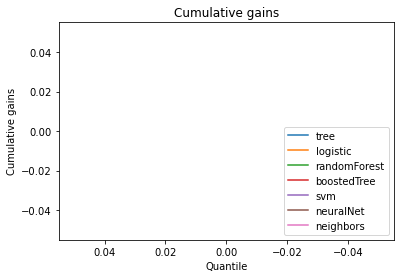

In [33]:
# gains plot
for model in models:
    pyplot.plot(gains[model]["Quantile"], gains[model]["Cumulative gains"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Cumulative gains")
    pyplot.title("Cumulative gains")
    # Add labels for the plot
    plt.legend(labels= models.keys(), loc='lower right')

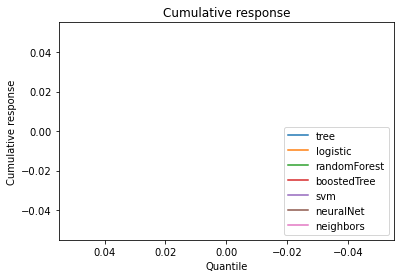

In [36]:
# responses plot
for model in models:
    pyplot.plot(responses[model]["Quantile"], responses[model]["Cumulative response"])
    pyplot.gca().invert_xaxis()
    pyplot.xlabel("Quantile")
    pyplot.ylabel("Cumulative response")
    pyplot.title("Cumulative response")
    # Add labels for the plot
    plt.legend(labels= models.keys(), loc='lower right')

In [37]:
# RFM Model

df = gifts_df.merge(campaigns_df, on = 'campaignID', how = 'left')
dfmerge = df.merge(donors_df, on = 'donorID', how = 'left')
dfmerge = dfmerge.rename(columns={'date_x':'gift_date','date_y':'campaign_date'})
dfmerge

dfmerge['date'] = pd.to_datetime(dfmerge['gift_date'])

today = datetime.datetime(2020,12,8)
rfmTable = dfmerge.groupby('donorID').agg({'date': lambda x: (today - x.max()).days, 'campaignID': lambda x: len(x), 'amount': lambda x: x.sum()})
rfmTable.rename(columns={'date': 'recency', 
                         'campaignID': 'frequency', 
                         'amount': 'monetary_value'}, inplace=True)
rfmTable.sort_values(by = ['monetary_value'],ascending=False)

#rfmTable.to_excel(r'C:\Users\bajpa\Desktop\IESEG\Predictive and Descriptive Analytics\Group Project\rfmTable.xlsx', index = True, header = True)

,recency,frequency,monetary_value
donorID,,,
123168,3805,2.0,4000030.00
120861,4404,1.0,2479000.00
122679,3275,4.0,30120.00
105960,377,120.0,13830.37
109635,3906,7.0,13718.40
...,...,...,...
139760,2093,1.0,5.00
107811,3386,1.0,5.00
139762,2088,1.0,5.00
